In [1]:
import pandas as pd
import numpy as np
import cooler
import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib.patches import Patch
from matplotlib.offsetbox import AnchoredText
import scipy.io
from scipy.sparse import csgraph
from sklearn.metrics.pairwise import pairwise_distances
from scipy.linalg import toeplitz
import magic

from sklearn.decomposition import PCA
from scipy import stats
import networkx as nx
from sklearn.metrics import jaccard_score

import os
import sys
from importlib import reload

import filters
import imputation
import pore_c_utils as pcu
import binning_utils as binning
import plotting as hicPlot
import spectral

In [2]:
reload(pcu)

<module 'pore_c_utils' from '/home/cstansbu/git_repositories/scPoreC-analysis/notebooks/pore_c_utils.py'>

In [3]:
assembly = pcu.loadAssembly("GRCm39_Assembly.txt")

chromDict = dict(zip(assembly['RefSeq accession'],assembly['Chromosome'].apply(lambda x : f"chr{x}")))

# the reverse for easy lookup
chromDict_r = {v: k for k, v in chromDict.items()}
chromOrder = list(chromDict.values())
chromOrder

['chr1',
 'chr2',
 'chr3',
 'chr4',
 'chr5',
 'chr6',
 'chr7',
 'chr8',
 'chr9',
 'chr10',
 'chr11',
 'chr12',
 'chr13',
 'chr14',
 'chr15',
 'chr16',
 'chr17',
 'chr18',
 'chr19',
 'chrX',
 'chrY']

In [4]:
filepath = "filtered_data/nagano2017rpkm1MbMAPQ.csv"
rna = pd.read_csv(filepath)
print(f"{rna.shape=}")

rna.shape=(182, 5)


In [5]:
filepath = "filtered_data/clique1MBfiltered.csv"

df = pd.read_csv(filepath)
print(f"{df.shape=}")

filteredCells = {}

for runId in df['cell'].unique():
    tmp = df[df['cell'] == runId]
    filteredCells[runId] = tmp.reset_index(drop=True)
    

print(f"\n{filteredCells.keys()=}")

/sw/arcts/centos7/python3.8-anaconda/2020.07/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3343: DtypeWarning: Columns (39) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


df.shape=(636130, 65)

filteredCells.keys()=dict_keys(['run01', 'run02', 'run04', 'run05', 'run06', 'run07'])


In [6]:
resolution = 1000000 # 1mb scale

totalLength = assembly['chromEnd'].max()
bins = binning.getBins(totalLength, resolution)

label1 = 'bin1'
label2 = 'bin2'

binnedData = {}
matrices = {}

for runId, data in filteredCells.items():
    binned = binning.wholeGenomeBinData(data, bins, label1, label2)
    binnedData[runId] = binned
      
    A = pcu.getHic(binned, bins, label1, label2)
    print(f"{runId=} {A.shape=}")
    matrices[runId] = A
    
print(f"{matrices.keys()}")

runId='run01' A.shape=(2724, 2724)
runId='run02' A.shape=(2724, 2724)
runId='run04' A.shape=(2724, 2724)
runId='run05' A.shape=(2724, 2724)
runId='run06' A.shape=(2724, 2724)
runId='run07' A.shape=(2724, 2724)
dict_keys(['run01', 'run02', 'run04', 'run05', 'run06', 'run07'])


In [7]:
newRows = []

for idx, row in assembly.iterrows():
    if "NC" in row['RefSeq accession']:
        
        start = binning.returnBin(row['chromStart'], bins) + 2
        end = binning.returnBin(row['chromEnd'], bins) + 3
        
        newRow = {
            'region' : f"chr{row['Chromosome']}",
            'start' : start,
            'end' : end,
            'length' : end - start,
        }
        
        newRows.append(newRow)
        
filteredChromInfo = pd.DataFrame(newRows)
filteredChromInfo

,region,start,end,length
0,chr1,1,197,196
1,chr2,196,378,182
2,chr3,377,538,161
3,chr4,537,695,158
4,chr5,694,847,153
5,chr6,846,996,150
6,chr7,995,1141,146
7,chr8,1140,1271,131
8,chr9,1270,1396,126
9,chr10,1395,1526,131


In [8]:
filteredPoreCIndex = list(range(0, len(matrices['run01'])))
print(f"{len(filteredPoreCIndex)=}")

len(filteredPoreCIndex)=2724


# Load raw data

In [9]:
matricesCh2 = {}
rawMatricesChr2 = {}
chromosome = ['chr2']

for runId, mat in matrices.items():
     
    ind = pcu.getIndices(filteredChromInfo, filteredPoreCIndex, chromosome, 'region')
    A = mat[:, ind][ind, :]
    
    A = np.where(A > 0, 1, 0)
    
    rawMatricesChr2[runId] = A
    
    # force diagonal and force adjacent connections
    A = pcu.dropZeroRows(A, threshold=1)
    np.fill_diagonal(A, 1)
    A = pcu.forceAdjacentConnections(A)
    
    print(f"{runId=} {A.shape=}")
    
    matricesCh2[runId] = A

print(matricesCh2.keys())
print('done.')


runId='run01' A.shape=(176, 176)
runId='run02' A.shape=(174, 174)
runId='run04' A.shape=(147, 147)
runId='run05' A.shape=(164, 164)
runId='run06' A.shape=(165, 165)
runId='run07' A.shape=(168, 168)
dict_keys(['run01', 'run02', 'run04', 'run05', 'run06', 'run07'])
done.


# Distribution of Connected Components

In [10]:
for runId, A in rawMatricesChr2.items():
    
    # get Laplacian
    L = csgraph.laplacian(A, normed=True)
    w, v = np.linalg.eigh(L)
        
    fIndx = 1 # second position
    
    fiedlerNumber = w[fIndx]
    fiedlerVector = v[:, fIndx]
    
    eigs = [np.abs(round(i, 2)) for i in np.flip(w)]
    eps = 1.e-22
    zeroValuedEigs = np.sum(np.absolute(eigs) < eps)
    print(f"{runId=} {zeroValuedEigs=} {L.shape=} {fiedlerNumber=:.4f}")

runId='run01' zeroValuedEigs=7 L.shape=(182, 182) fiedlerNumber=-0.0000
runId='run02' zeroValuedEigs=7 L.shape=(182, 182) fiedlerNumber=-0.0000
runId='run04' zeroValuedEigs=40 L.shape=(182, 182) fiedlerNumber=-0.0000
runId='run05' zeroValuedEigs=23 L.shape=(182, 182) fiedlerNumber=-0.0000
runId='run06' zeroValuedEigs=17 L.shape=(182, 182) fiedlerNumber=-0.0000
runId='run07' zeroValuedEigs=16 L.shape=(182, 182) fiedlerNumber=-0.0000


# Fiedler Vector 

/home/cstansbu/git_repositories/scPoreC-analysis/notebooks/pore_c_utils.py:603: RuntimeWarning: invalid value encountered in true_divide
  A = np.divide(O, E)


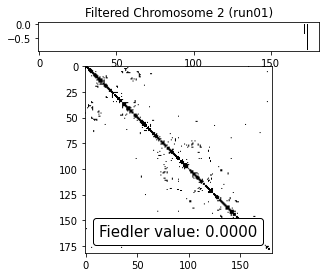

In [11]:
plt.rcParams['figure.dpi'] = 150
plt.rcParams['figure.figsize'] = 6, 6

for runId, A in rawMatricesChr2.items():
    
    Anormed = pcu.normalizeToeplitz(A)
    
    # get Laplacian
    L = csgraph.laplacian(Anormed, normed=True)
    w, v = np.linalg.eigh(L)
    
    fIndx = 1 # second position
    fiedlerNumber = np.abs(w[fIndx])
    fiedlerVector = v[:, fIndx]
    
    left, width = 0.1, 0.65
    bottom, height = 0.1, 0.65
    spacing = 0.05

    hicPlotSize = [left, bottom, width, height]
    barPlotSize = [left, bottom + height + spacing, width, 0.1]

    fig = plt.figure()
    
    ax1 = fig.add_axes(hicPlotSize)
    ax1.imshow(A, cmap='binary')
    
    at = AnchoredText(
        f"Fiedler value: {fiedlerNumber:.4f}", prop=dict(size=15), frameon=True, loc='lower left')
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    ax1.add_artist(at)
    

    ax2 = fig.add_axes(barPlotSize, sharex=ax1)
    ax2.bar(range(len(fiedlerVector)), fiedlerVector, color='k')
    
    ax2.set_title(f'Filtered Chromosome 2 ({runId})')
    
    plt.show()
    break

In [12]:
for runId, A in matricesCh2.items():
    
    # get Laplacian
    L = csgraph.laplacian(A, normed=True)
    w, v = np.linalg.eigh(L)
        
    fIndx = 1 # second position
    
    fiedlerNumber = w[fIndx]
    fiedlerVector = v[:, fIndx]
    
    eigs = [np.abs(round(i, 2)) for i in np.flip(w)]
    eps = 1.e-22
    zeroValuedEigs = np.sum(np.absolute(eigs) < eps)
    print(f"{runId=} {zeroValuedEigs=} {L.shape=} {fiedlerNumber=:.4f}")

    
print('done.')

runId='run01' zeroValuedEigs=1 L.shape=(176, 176) fiedlerNumber=0.0154
runId='run02' zeroValuedEigs=1 L.shape=(174, 174) fiedlerNumber=0.0496
runId='run04' zeroValuedEigs=1 L.shape=(147, 147) fiedlerNumber=0.0233
runId='run05' zeroValuedEigs=1 L.shape=(164, 164) fiedlerNumber=0.1111
runId='run06' zeroValuedEigs=1 L.shape=(165, 165) fiedlerNumber=0.0337
runId='run07' zeroValuedEigs=1 L.shape=(168, 168) fiedlerNumber=0.0540
done.


# Locally Connected

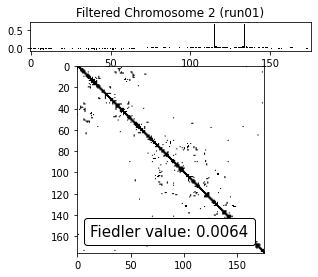

In [13]:
for runId, A in matricesCh2.items():
    
    # normalize by diagonal
    Anormed = pcu.normalizeToeplitz(A)
    
    # get Laplacian
    L = csgraph.laplacian(Anormed, normed=True)
    w, v = np.linalg.eigh(L)
    
    fIndx = 1 # second position
    
    fiedlerNumber = w[fIndx]
    fiedlerVector = v[:, fIndx]
    
    left, width = 0.1, 0.65
    bottom, height = 0.1, 0.65
    spacing = 0.05

    hicPlotSize = [left, bottom, width, height]
    barPlotSize = [left, bottom + height + spacing, width, 0.1]

    fig = plt.figure()
    
    ax1 = fig.add_axes(hicPlotSize)
    ax1.imshow(A, cmap='binary')
    
    at = AnchoredText(
        f"Fiedler value: {fiedlerNumber:.4f}", prop=dict(size=15), frameon=True, loc='lower left')
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    ax1.add_artist(at)
    

    ax2 = fig.add_axes(barPlotSize, sharex=ax1)
    ax2.bar(range(len(fiedlerVector)), fiedlerVector, color='k')
    
    ax2.set_title(f'Filtered Chromosome 2 ({runId})')
    
    plt.show()
    break

# Imputation

runId='run01' fiedlerNumber=0.1581


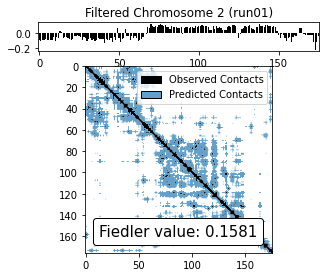

In [14]:
tau = 0.5

for runId, A in matricesCh2.items():
#     # normalize by diagonal
#     A = pcu.normalizeToeplitz(A)
    
    # impute
    Ahat = imputation.imputeEdges(A, tau, method=4, return_scores=False) 

    Anormed = pcu.normalizeToeplitz(Ahat)
    
    # get Laplacian
    L = csgraph.laplacian(Anormed, normed=True)
    w, v = np.linalg.eigh(L)
    
    fIndx = 1 # second position
    
    fiedlerNumber = w[fIndx]
    fiedlerVector = v[:, fIndx]
    
    print(f"{runId=} {fiedlerNumber=:.4f}")
    
    left, width = 0.1, 0.65
    bottom, height = 0.1, 0.65
    spacing = 0.05

    hicPlotSize = [left, bottom, width, height]
    barPlotSize = [left, bottom + height + spacing, width, 0.1]
    
    c_white = matplotlib.colors.colorConverter.to_rgba('white', alpha = 0)
    c_black = matplotlib.colors.colorConverter.to_rgba('black', alpha = 1)
    
    c_C0 = matplotlib.colors.colorConverter.to_rgba('C0', alpha = 0.7)

    cmap1 = matplotlib.colors.LinearSegmentedColormap.from_list('cmap1',[c_white, c_black], 512)
    cmap2 = matplotlib.colors.LinearSegmentedColormap.from_list('cmap2',[c_white, c_C0], 512)

    fig = plt.figure()
    
    ax1 = fig.add_axes(hicPlotSize)
    ax1.imshow(Ahat, cmap=cmap2)
    ax1.imshow(A, cmap=cmap1)
    
        
    at = AnchoredText(
        f"Fiedler value: {fiedlerNumber:.4f}", prop=dict(size=15), frameon=True, loc='lower left')
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    ax1.add_artist(at)
    
     
    legend_elements = [Patch(facecolor='k', edgecolor='k', label='Observed Contacts'),
                       Patch(facecolor=c_C0, edgecolor='k', label='Predicted Contacts'),]
    
    ax1.legend(handles=legend_elements)

    ax2 = fig.add_axes(barPlotSize, sharex=ax1)
    ax2.bar(range(len(fiedlerVector)), fiedlerVector, color='k')
    
    ax2.set_title(f'Filtered Chromosome 2 ({runId})')
    
    plt.show()
    break

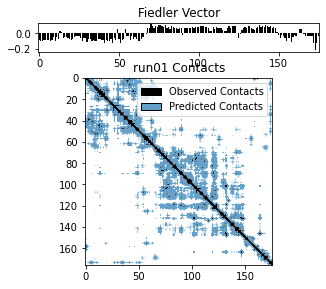

In [15]:
for runId, A in matricesCh2.items():
    
    # impute
    Ahat = imputation.imputeEdges(A, tau, method=4, return_scores=False) 
    Anormed = pcu.normalizeToeplitz(Ahat)

    # get Laplacian
    L = csgraph.laplacian(Anormed, normed=True)
    w, v = np.linalg.eigh(L)
    
    fIndx = 1 # second position
    
    fiedlerNumber = w[fIndx]
    fiedlerVector = v[:, fIndx]
    
    left, width = 0.1, 0.65
    bottom, height = 0.1, 0.65
    spacing = 0.05

    hicPlotSize = [left, bottom, width, height]
    newBottom = bottom + 0.69 + spacing
    barPlotSize = [left, newBottom, width, 0.1]
    
    fig = plt.figure()
    
    ax1 = fig.add_axes(hicPlotSize)
    ax1.imshow(Ahat, cmap=cmap2)
    ax1.imshow(A, cmap=cmap1)
    ax1.set_title(f'{runId} Contacts')
       
    legend_elements = [Patch(facecolor='k', edgecolor='k', label='Observed Contacts'),
                       Patch(facecolor=c_C0, edgecolor='k', label='Predicted Contacts'),]
    
    ax1.legend(handles=legend_elements)
    
    ax2 = fig.add_axes(barPlotSize, sharex=ax1)
    ax2.bar(range(len(fiedlerVector)), fiedlerVector, color='k')
    ax2.set_title(f'Fiedler Vector')
    
    
    break

In [16]:
# break

# Ensemble Pore-C Contact Maps

Text(0.5, 1.0, 'Normalized Matrix')

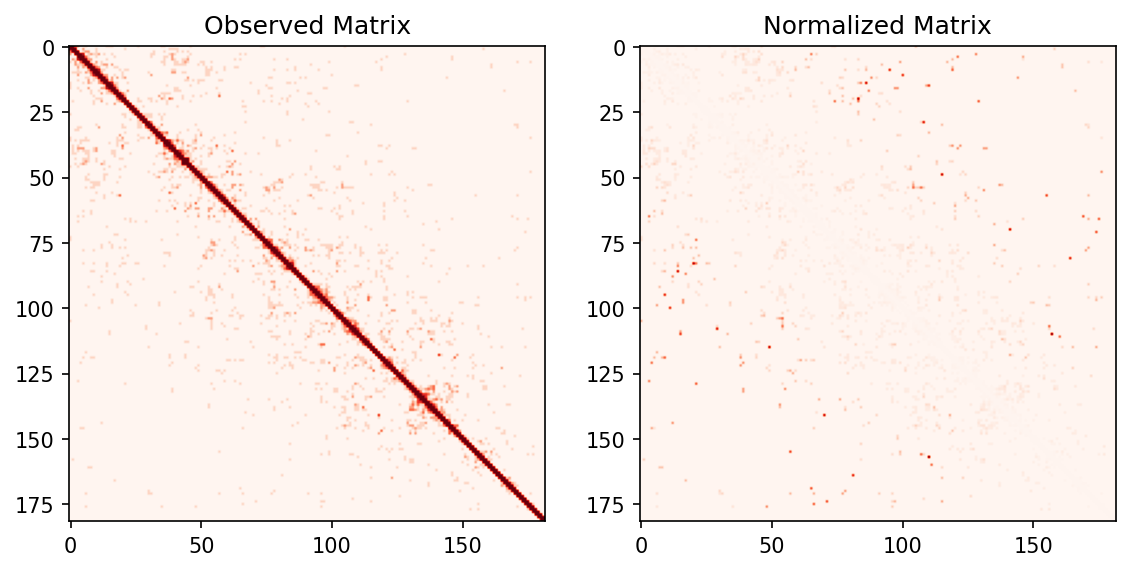

In [17]:
Apool = np.zeros((182, 182))

for runId, A in rawMatricesChr2.items():
    np.fill_diagonal(A, 1)
    A = pcu.forceAdjacentConnections(A)
    Apool += A
    
# Apool = pcu.dropZeroRows(Apool, threshold=0)
Anormed = pcu.normalizeToeplitz(Apool)

plt.rcParams['figure.dpi'] = 150
plt.rcParams['figure.figsize'] = 9,9

fig = plt.figure()

fig.add_subplot(121)
plt.imshow(Apool, cmap='Reds')
plt.title('Observed Matrix')


fig.add_subplot(122)
plt.imshow(Anormed, cmap='Reds')
plt.title('Normalized Matrix')

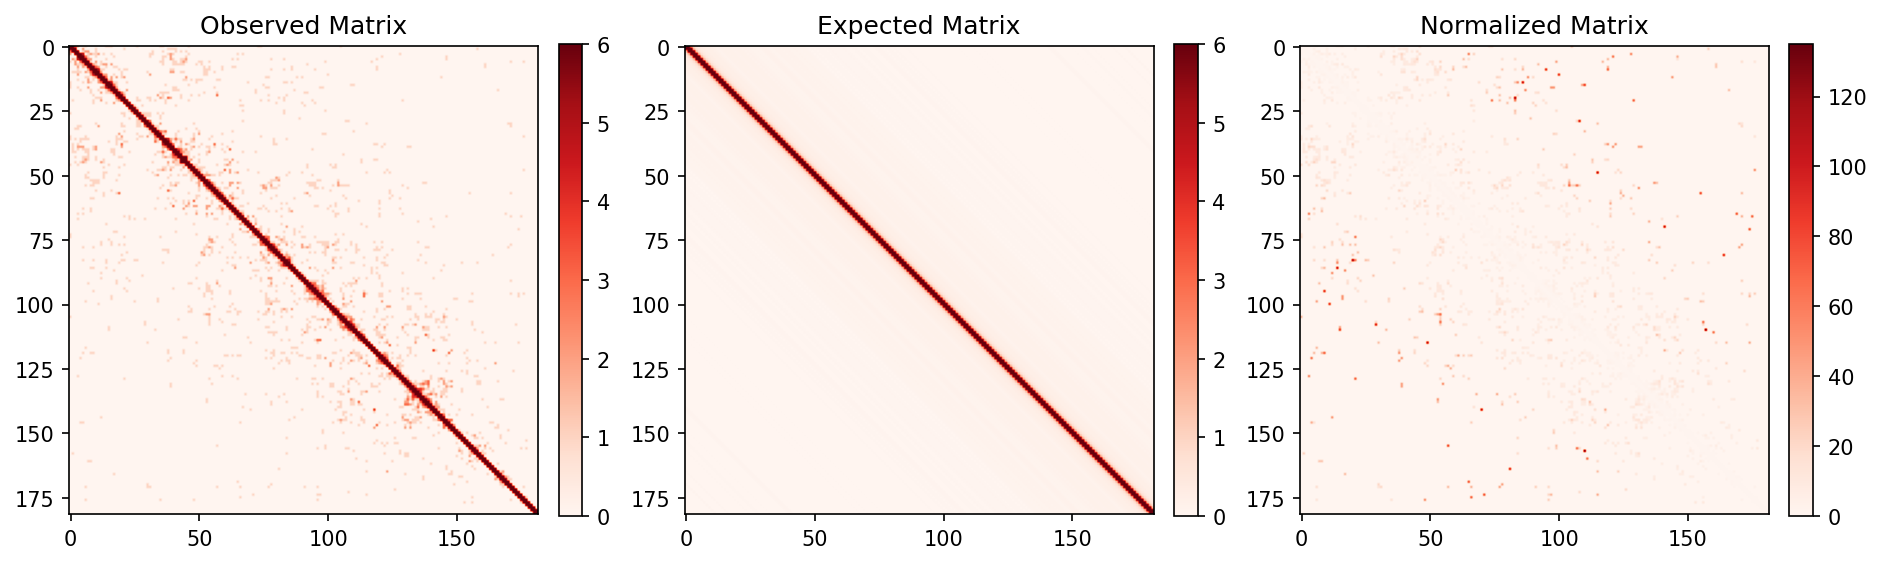

In [18]:
Aobserved = np.zeros((182, 182))

for runId, A in rawMatricesChr2.items():
    A = np.where(A > 0, 1 , 0)
    np.fill_diagonal(A, 1)
    A = pcu.forceAdjacentConnections(A)
    Aobserved += A
    
Aexpected = pcu.getToeplitz(Aobserved)
Anormed = pcu.normalizeToeplitz(Aobserved)

matlabDict = {
    'O' : Aobserved,
    'E' : Aexpected,
    'A' : Anormed,
}

scipy.io.savemat('MATLAB_data/AOE.mat', matlabDict)

plt.rcParams['figure.dpi'] = 150
plt.rcParams['figure.figsize'] = 15, 15

fig = plt.figure()

fig.add_subplot(131)
plt.imshow(Aobserved, cmap='Reds')
plt.title('Observed Matrix')
plt.colorbar(fraction=0.046, pad=0.04)

fig.add_subplot(132)
plt.imshow(Aexpected, cmap='Reds')
plt.title('Expected Matrix')
plt.colorbar(fraction=0.046, pad=0.04)

fig.add_subplot(133)
plt.imshow(Anormed, cmap='Reds')
plt.title('Normalized Matrix')
plt.colorbar(fraction=0.046, pad=0.04)

(178, 178)


Text(0.5, 1.0, 'Gene Expression (rpkm)')

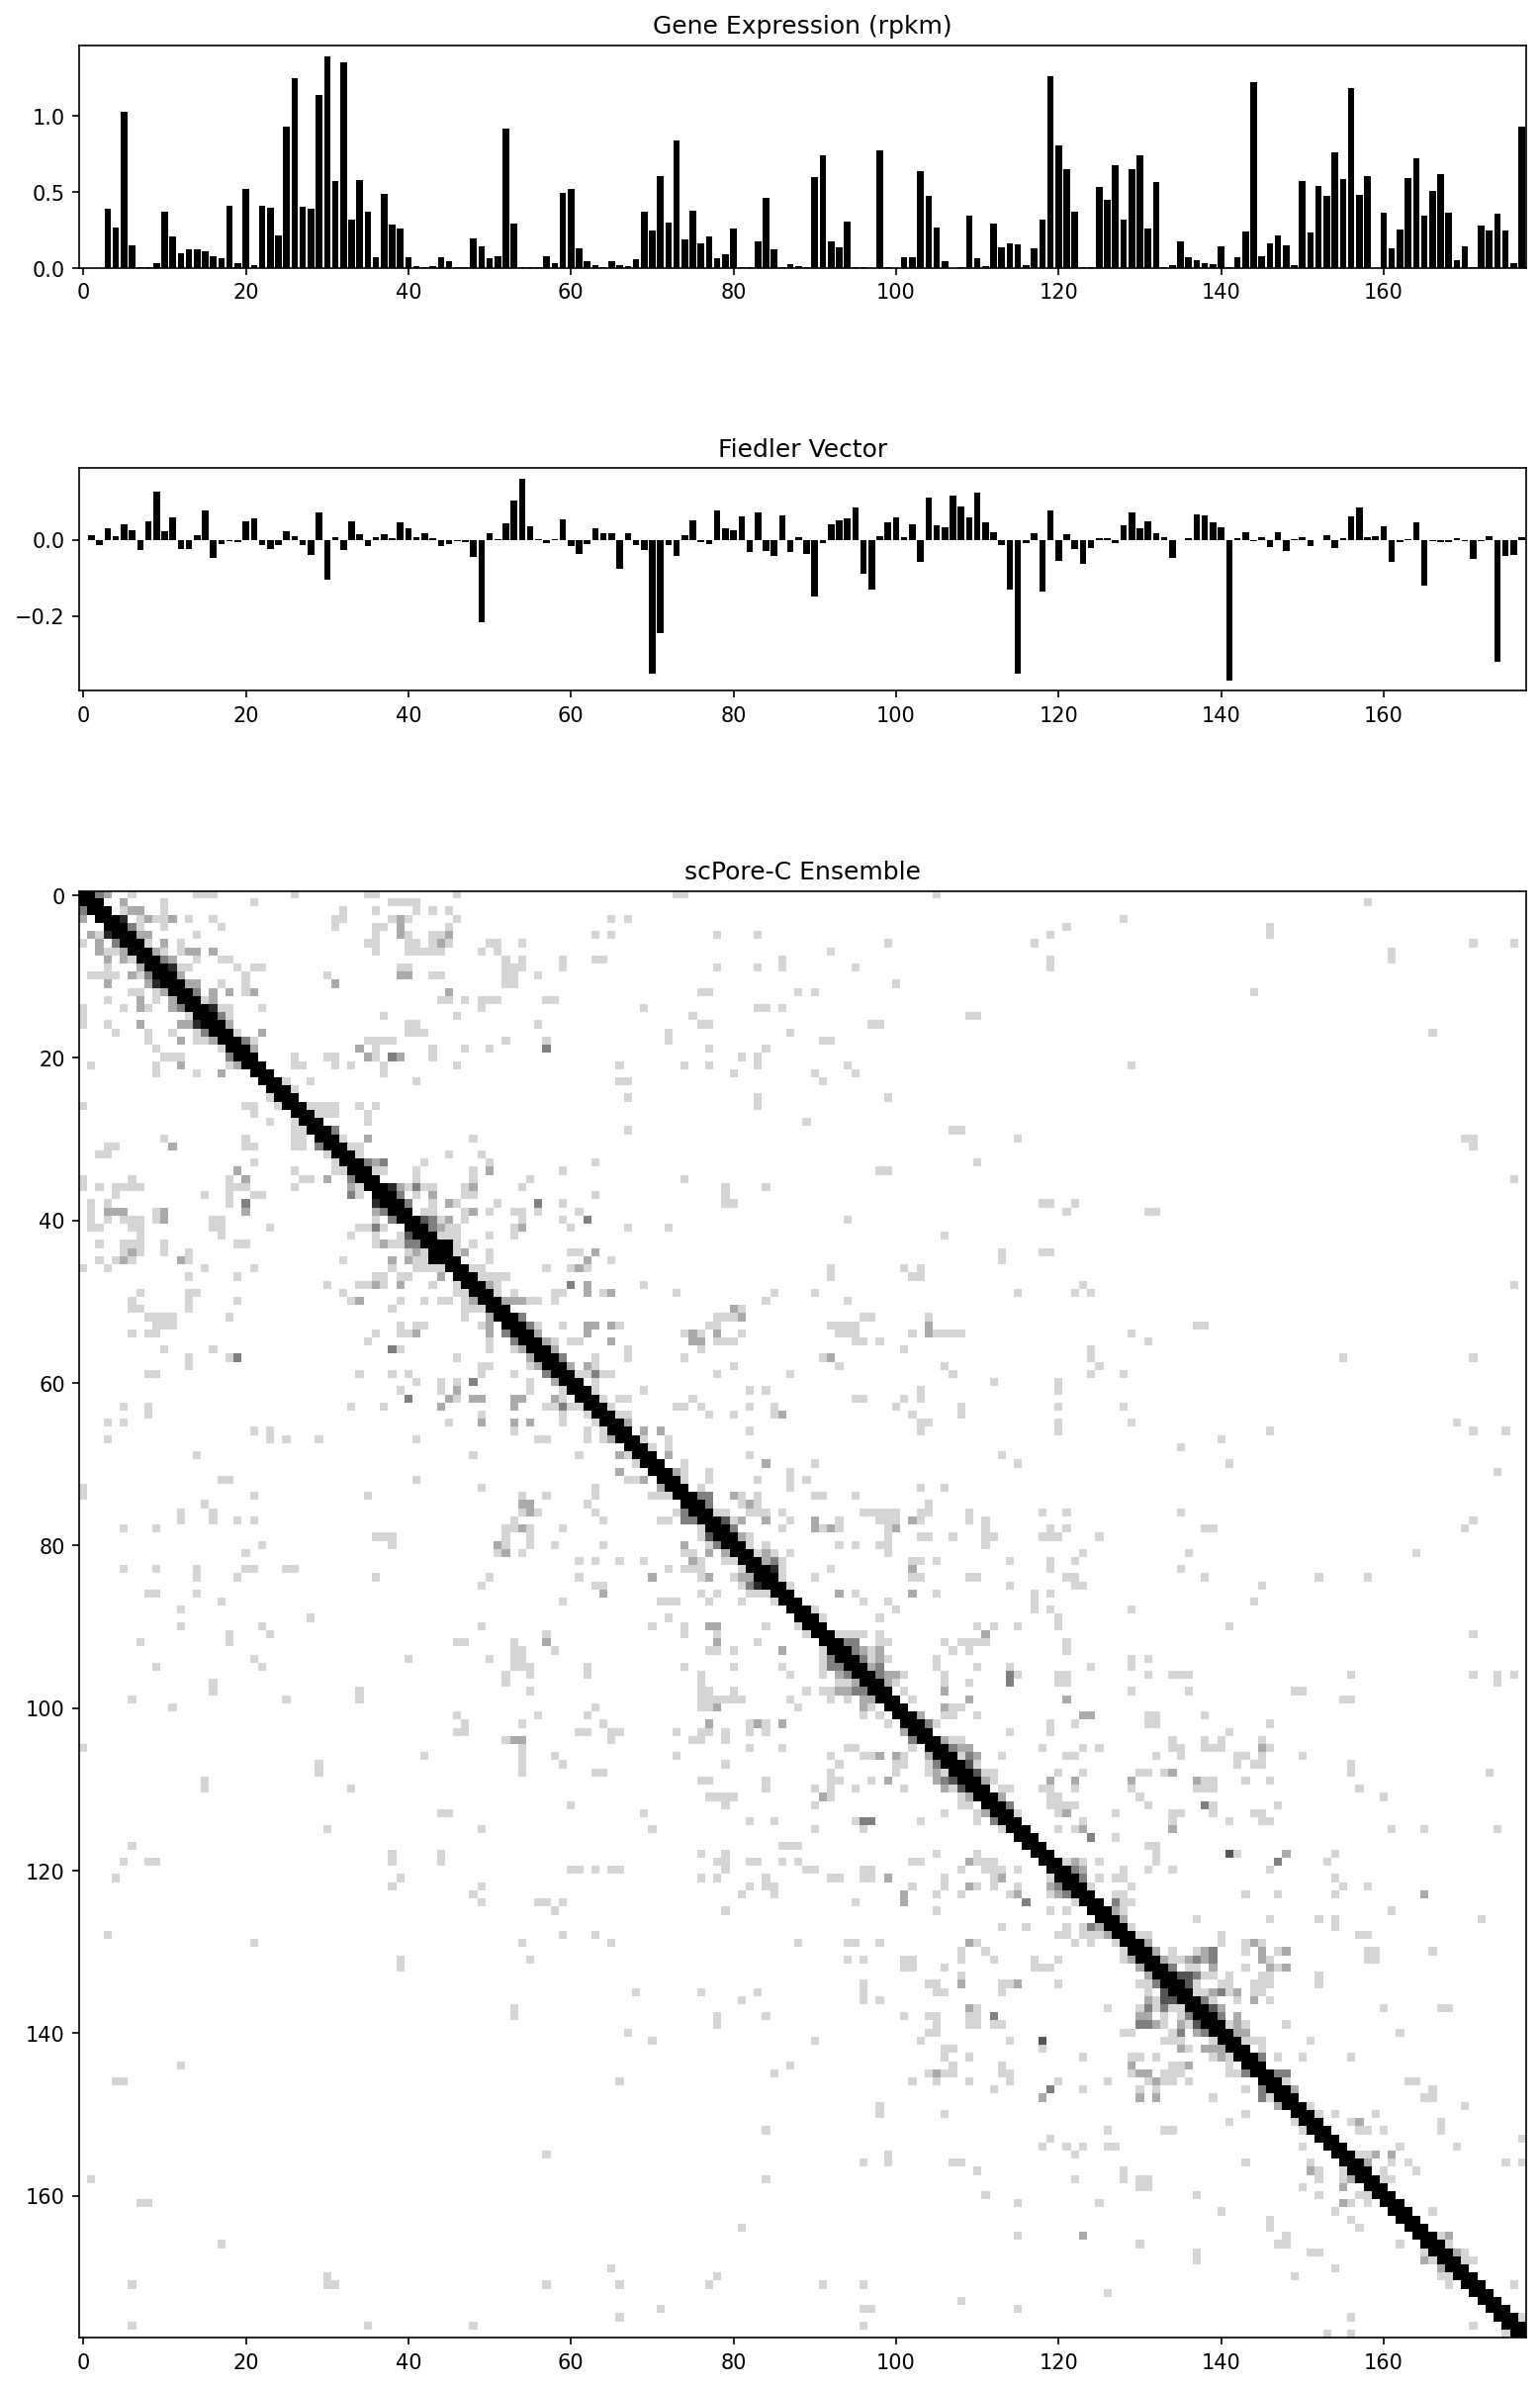

In [19]:
# create ensemble
Apool = np.zeros((182, 182))

d = 0.5

for runId, A in rawMatricesChr2.items():
    A = np.where(A > 0, 1 , 0)
    np.fill_diagonal(A, 1)
    A = pcu.forceAdjacentConnections(A)
    Apool += A
    
Apool, rmInd = pcu.dropZeroRows(Apool, threshold=18, return_ind=True)
Aplot = np.where(Apool > 0, 1, 0)
Apool = pcu.pageRankNorm(Apool, d=d)
print(f"{Apool.shape}")

# normalize
Anormed = pcu.normalizeToeplitz(Apool)

# compute fiedler vector
L = csgraph.laplacian(Anormed, normed=True)
w, v = np.linalg.eigh(L)
fIndx = 1 # second position
fiedlerNumber = w[fIndx]
fiedlerVector = v[:, fIndx]
ensembleFied = fiedlerVector.copy()

"""
plot
"""

left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.05

hicPlotSize = [left, bottom, width, height]
newBottom = bottom + 0.69 + spacing
barPlotSize = [left, newBottom, width, 0.1]
barPlotSize2 = [left, newBottom + 0.14 + spacing, width, 0.1]

fig = plt.figure()
    
ax1 = fig.add_axes(hicPlotSize)

ax1.imshow(Apool, cmap='binary')
ax1.set_title(f'scPore-C Ensemble')

ax2 = fig.add_axes(barPlotSize, sharex=ax1)
ax2.bar(range(len(fiedlerVector)), fiedlerVector, color='k')
ax2.set_title(f'Fiedler Vector')

# remove the dropped bins
rpkm = rna['rpkm'].to_numpy()
rpkm = np.delete(rpkm, rmInd)

ax3 = fig.add_axes(barPlotSize2, sharex=ax1)
ax3.bar(range(len(fiedlerVector)), rpkm, color='k')
ax3.set_title(f'Gene Expression (rpkm)')

In [20]:
# break

# Pool of Imputes

(174, 174)


Text(0.5, 1.0, 'Gene Expression (rpkm)')

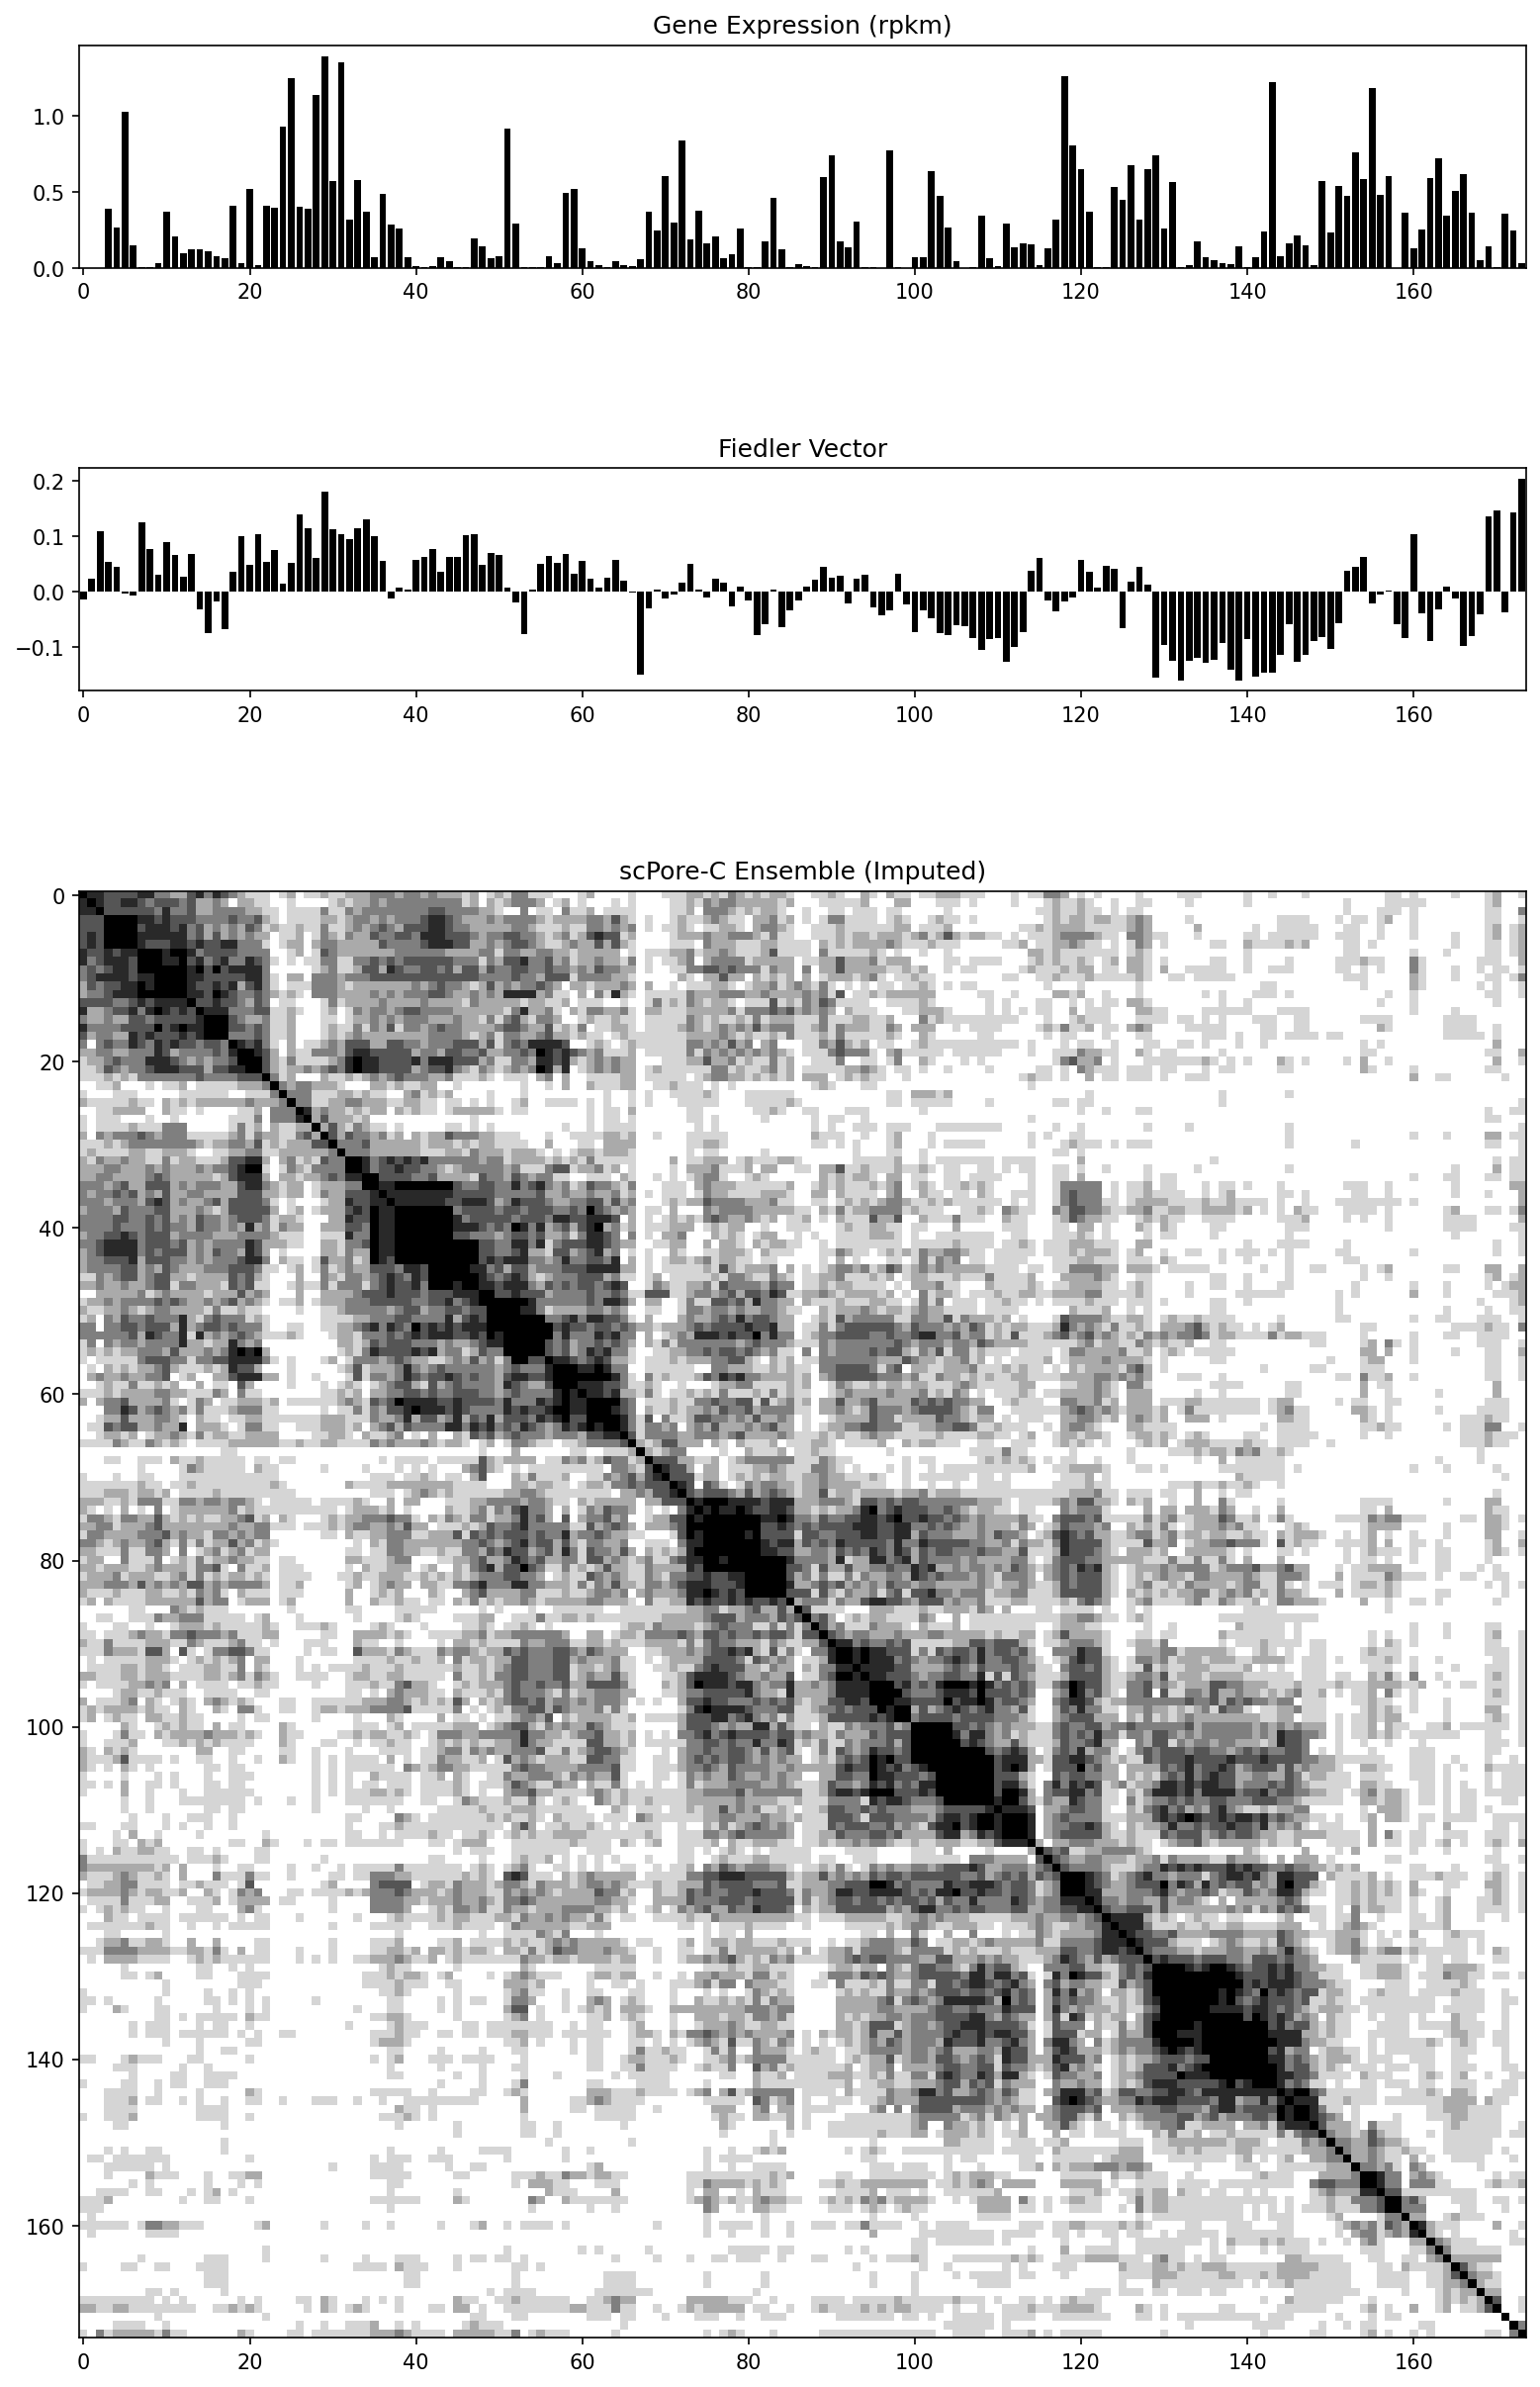

In [21]:
# create ensemble
Apool = np.zeros((182, 182))

tau = 0.6
d = 0.5

for runId, A in rawMatricesChr2.items():
    A = np.where(A > 0, 1 , 0)
    np.fill_diagonal(A, 1)
#     A = pcu.forceAdjacentConnections(A)
    A = imputation.imputeEdges(A, tau, method=4, return_scores=False) 
    Apool += A
    
Apool, rmInd = pcu.dropZeroRows(Apool, threshold=50, return_ind=True)
Apool = pcu.pageRankNorm(Apool, d=d)
print(f"{Apool.shape}")

# normalize
Anormed = pcu.normalizeToeplitz(Apool)

# compute fiedler vector
L = csgraph.laplacian(Anormed, normed=True)
w, v = np.linalg.eigh(L)
fIndx = 1 # second position
fiedlerNumber = w[fIndx]
fiedlerVector = v[:, fIndx]
imputedFied = fiedlerVector.copy()

"""
plot
"""

left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.05

hicPlotSize = [left, bottom, width, height]
newBottom = bottom + 0.69 + spacing
barPlotSize = [left, newBottom, width, 0.1]
barPlotSize2 = [left, newBottom + 0.14 + spacing, width, 0.1]

fig = plt.figure()
    
ax1 = fig.add_axes(hicPlotSize)
ax1.imshow(Apool, cmap='binary')
ax1.set_title(f'scPore-C Ensemble (Imputed)')


ax2 = fig.add_axes(barPlotSize, sharex=ax1)
ax2.bar(range(len(fiedlerVector)), fiedlerVector, color='k')
ax2.set_title(f'Fiedler Vector')

# remove the dropped bins
rpkm = rna['rpkm'].to_numpy()
rpkm = np.delete(rpkm, rmInd)

ax3 = fig.add_axes(barPlotSize2, sharex=ax1)
ax3.bar(range(len(fiedlerVector)), rpkm, color='k')
ax3.set_title(f'Gene Expression (rpkm)')

In [22]:
# plt.rcParams['figure.dpi'] = 100
# plt.rcParams['figure.figsize'] = 5, 2 

# # create ensemble
# Apool = np.zeros((182, 182))

# tau = 0.55

# for runId, A in rawMatricesChr2.items():
# #     np.fill_diagonal(A, 1)
# #     A = pcu.forceAdjacentConnections(A)
#     Ahat = imputation.imputeEdges(A, tau, method=4, return_scores=False) 
#     Apool += Ahat
    
    
# for t in range(20, 100, 10):
#     Apool = pcu.dropZeroRows(Apool, threshold=t)
#     print(f"{Apool.shape}")

#     # normalize
#     Anormed = pcu.normalizeToeplitz(Apool)

#     # compute principal eigenvector
#     Acorr = np.corrcoef(Anormed)
#     u, s, vh = np.linalg.svd(Acorr)
#     pc1 = u[:, 1]

#     # compute fiedler vector
#     L = csgraph.laplacian(Anormed, normed=True)
#     w, v = np.linalg.eigh(L)
#     fIndx = 1 # second position
#     fiedlerNumber = w[fIndx]
#     fiedlerVector = v[:, fIndx]
    
#     plt.bar(range(len(fiedlerVector)), fiedlerVector, alpha=0.5, label='fVec')
#     plt.bar(range(len(pc1)), -1* pc1, alpha=0.5, label='PC1')
#     plt.legend()
#     plt.title(t)
#     plt.show()

In [23]:
# # create ensemble
# Apool = np.zeros((182, 182))

# tau = 0.5

# for runId, A in rawMatricesChr2.items():
#     A = np.where(A > 0, 1, 0)
#     np.fill_diagonal(A, 1)
# #     A = pcu.forceAdjacentConnections(A)
#     Ahat = imputation.imputeEdges(A, tau, method=4, return_scores=False) 
#     Apool += Ahat
    
# Apool = pcu.dropZeroRows(Apool, threshold=30)
# print(f"{Apool.shape}")


# # normalize
# Apool = pcu.pageRankNorm(Apool, d=0.1)
# Anormed = pcu.normalizeToeplitz(Apool)

# # compute principal eigenvector
# Acorr = np.corrcoef(Anormed)
# u, s, vh = np.linalg.svd(Acorr)



# # plt.rcParams['figure.figsize'] = 5, 3
# # plt.plot(s[:5], marker='o')
# # plt.title('Eigenvalues of Correlation Matrix')
# # plt.xlabel('Eigenvalue Index')
# # plt.ylabel('Eigenvalue Magnitude')


# pc1 = u[:, 1]

# # compute fiedler vector
# L = csgraph.laplacian(Anormed, normed=True)
# w, v = np.linalg.eigh(L)
# fIndx = 1 # second position
# fiedlerNumber = w[fIndx]
# fiedlerVector = v[:, fIndx]

# print(f"max L eig {np.max(w):.4f}")
# print(f"min L eig {np.min(w):.4f}")


# """
# plot
# """
# plt.rcParams['figure.dpi'] = 150
# plt.rcParams['figure.figsize'] = 9,9

# left, width = 0.1, 0.65
# bottom, height = 0.1, 0.65
# spacing = 0.05

# hicPlotSize = [left, bottom, width, height]
# newBottom = bottom + 0.69 + spacing
# barPlotSize = [left, newBottom, width, 0.1]
# barPlotSize2 = [left, newBottom + 0.14 + spacing, width, 0.1]

# fig = plt.figure()
    
# ax1 = fig.add_axes(hicPlotSize)
# Aplot = Apool
# ax1.imshow(Aplot, cmap='binary')
# ax1.set_title(f'Imputed scPore-C Ensemble')

# ax2 = fig.add_axes(barPlotSize, sharex=ax1)
# ax2.bar(range(len(pc1)), pc1, color='k')
# ax2.set_title(f'Second Eigenvector')

# ax3 = fig.add_axes(barPlotSize2, sharex=ax1)
# ax3.bar(range(len(fiedlerVector)), fiedlerVector, color='k')
# ax3.set_title(f'Fiedler Vector')

# Imputed MAGIC

In [24]:
reload(pcu)

<module 'pore_c_utils' from '/home/cstansbu/git_repositories/scPoreC-analysis/notebooks/pore_c_utils.py'>

In [25]:
# # determine which bins to remove ahead of time 

# Apool = np.zeros((182, 182))

# for runId, A in rawMatricesChr2.items():
#     Apool += A

# Apool, rmInd = pcu.dropZeroRows(Apool, threshold=12, return_ind=True)
# print(f"{Apool.shape}")

In [26]:

# # flatten the arrays
# flat = []
# for runId, A in rawMatricesChr2.items():
#     A = np.asarray(A)
#     np.fill_diagonal(A, 1)
# #     A = pcu.forceAdjacentConnections(A)
    
#     A = np.delete(A, rmInd, axis=0)
#     A = np.delete(A, rmInd, axis=1)
    
#     Ashape = A.shape
#     flat.append(A.flatten())
    
# flat = np.asarray(flat)


# magic_operator = magic.MAGIC(verbose=False,
#                              knn=5,
#                              knn_max=5,
#                              t=10, 
#                              n_pca=1)

# multiCellPred = magic_operator.fit_transform(flat)

# Apool = np.zeros(Ashape)

# for i in range(multiCellPred.shape[0]):
#     cell = multiCellPred[i, :]
#     cell = cell.reshape(Ashape)
# #     cell = np.where(cell > 0, 1, 0)
#     Apool += cell
    
    
# # Apool = pcu.dropZeroRows(Apool, threshold=12)
# Anormed = pcu.normalizeToeplitz(Apool)

# plt.rcParams['figure.dpi'] = 150
# plt.rcParams['figure.figsize'] = 9,9

# fig = plt.figure()

# fig.add_subplot(121)
# plt.imshow(Apool, cmap='Reds')
# plt.title('Observed Matrix')

# fig.add_subplot(122)
# plt.imshow(Anormed, cmap='Reds')
# plt.title('Normalized Matrix')

# Compare to scHi-C

In [27]:
assembly = pcu.loadAssembly("GRCm39_Assembly.txt")

chromDict = dict(zip(assembly['RefSeq accession'],assembly['Chromosome'].apply(lambda x : f"chr{x}")))

# the reverse for easy lookup
chromDict_r = {v: k for k, v in chromDict.items()}

chromOrder = list(chromDict.values())

In [28]:
scHICfilepath = f"/nfs/turbo/umms-indikar/shared/projects/poreC/nagano_2017_data/nagano_1MB_raw_BALANCED.scool"
cellList = list(cooler.fileops.list_coolers(scHICfilepath))
print(f"{len(cellList)=}")

len(cellList)=3882


In [29]:
sampleSize = 100
chromosome = ['chr2']
sample = np.random.choice(cellList, sampleSize, replace=False)

hic = {}

for i, s in enumerate(sample):
    filetag = "_".join(s.split("_")[0:2]).replace("/", "") + f"_{i}"
    rawMat, hicChromInfo, hicIndex = pcu.loadNagano2017SingleCell(scHICfilepath, s, chromOrder, balance=False)
    
    hicChromInfo = hicChromInfo[hicChromInfo['region'].str.contains('random') == False]
    
    # re-order  the matrix
    hicMat = rawMat[hicIndex, :][:, hicIndex]
    
    # extract the second chromosome
    chrHicInd = pcu.getIndices(hicChromInfo, hicIndex, chromosome, 'region')

    A = hicMat[chrHicInd, :][:, chrHicInd]
   
    # binarize 
    A = np.where(A > 0, 1, 0)
    hic[filetag] = A
#     print(f"{filetag=} {A.shape=}")
    
print('done.')
print(f"{len(hic.keys())=}")

done.
len(hic.keys())=100


In [30]:
hicMatrices = {}

for runId, A in hic.items():
    
    A = np.where(A > 0, 1, 0)
    
    # force diagonal and force adjacent connections
    A = pcu.dropZeroRows(A, threshold=1)
    np.fill_diagonal(A, 1)
    A = pcu.forceAdjacentConnections(A)
#     print(f"{runId=} {A.shape=}")
    
    hicMatrices[runId] = A
    
print('done.')


done.


# scHi-C Fiedler Vector Analysis

In [31]:
# nKeys = 1
# sampleKeys = np.random.choice(list(hicMatrices.keys()), nKeys, replace=False)

# for runId in sampleKeys:
#     A = hicMatrices[runId]
    
#     Anormed = pcu.normalizeToeplitz(A)
    
#     # get Laplacian
#     L = csgraph.laplacian(Anormed, normed=True)
#     w, v = np.linalg.eigh(L)
    
#     fIndx = 1 # second position
    
#     fiedlerNumber = w[fIndx]
#     fiedlerVector = v[:, fIndx]
    
#     left, width = 0.1, 0.65
#     bottom, height = 0.1, 0.65
#     spacing = 0.05

#     hicPlotSize = [left, bottom, width, height]
#     barPlotSize = [left, bottom + height + spacing, width, 0.1]

#     fig = plt.figure()
    
#     ax1 = fig.add_axes(hicPlotSize)
#     ax1.imshow(A, cmap='binary')
    
#     at = AnchoredText(
#         f"Fiedler value: {fiedlerNumber:.4f}", prop=dict(size=15), frameon=True, loc='lower left')
#     at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
#     ax1.add_artist(at)
    

#     ax2 = fig.add_axes(barPlotSize, sharex=ax1)
#     ax2.bar(range(len(fiedlerVector)), fiedlerVector, color='k')
    
#     ax2.set_title(f'Chromosome 2 ({runId})')
    
#     plt.show()
#     break

# Pooled scHi-C 

Text(0.5, 1.0, 'Normalized Matrix')

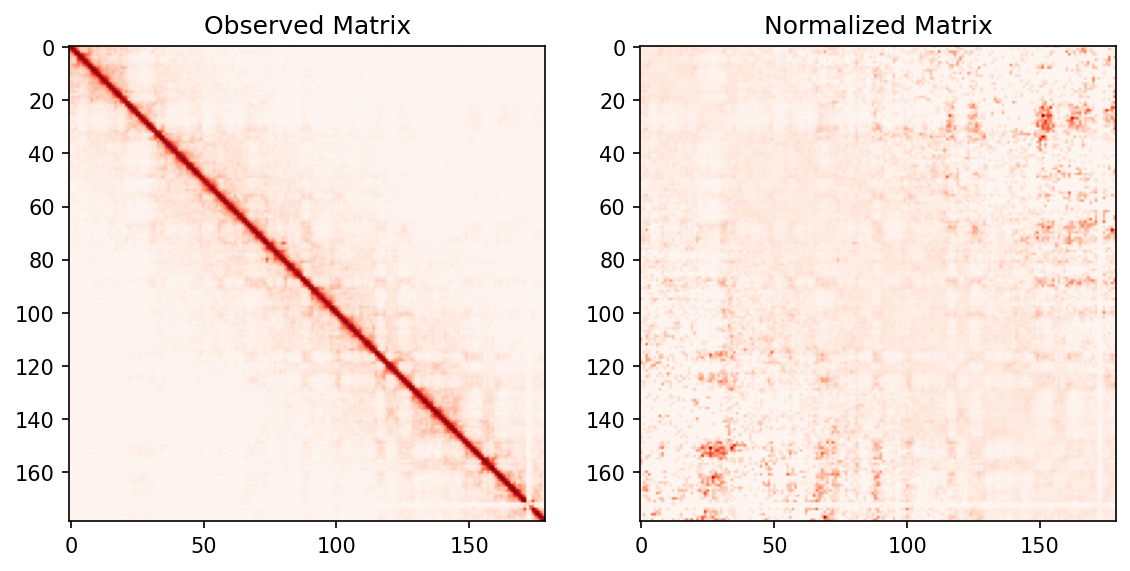

In [32]:
reload(pcu)


Apool = np.zeros((182, 182))

for runId, A in hic.items():
    Apool += A

Apool = pcu.dropZeroRows(Apool, threshold=1)
Anormed = pcu.normalizeToeplitz(Apool)

plt.rcParams['figure.dpi'] = 150
plt.rcParams['figure.figsize'] = 9,9

fig = plt.figure()

fig.add_subplot(121)
plt.imshow(Apool, cmap='Reds')
plt.title('Observed Matrix')

fig.add_subplot(122)
plt.imshow(Anormed, cmap='Reds')
plt.title('Normalized Matrix')

<ipython-input-33-65562fd99160>:37: RuntimeWarning: divide by zero encountered in log
  Aplot = np.where(Apool > 0, np.log(Apool), Apool)


Text(0.5, 1.0, 'Gene Expression (rpkm)')

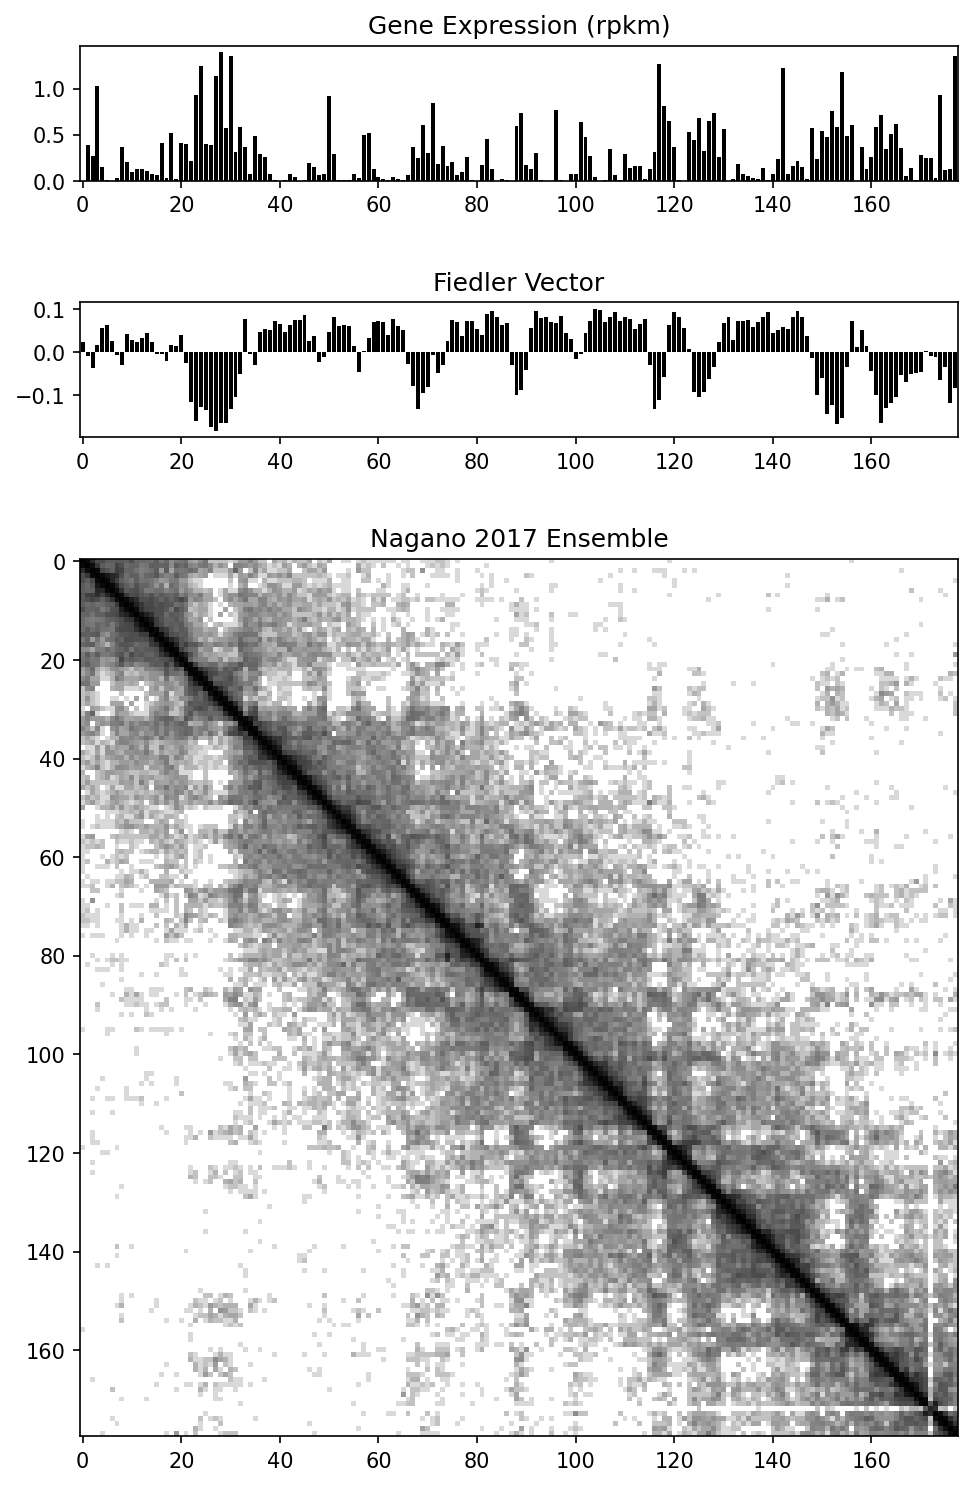

In [33]:
# pc1
Apool = np.zeros((182, 182))

n = 100
sampleKeys = np.random.choice(list(hic.keys()), n, replace=False)

for key in sampleKeys:
    Apool += hic[key]

Apool, rmInd = pcu.dropZeroRows(Apool, threshold=100, return_ind=True)
Anormed = pcu.normalizeToeplitz(Apool)


# get Laplacian
L = csgraph.laplacian(Anormed, normed=True)
w, v = np.linalg.eigh(L)

fIndx = 1 # second position

fiedlerNumber = w[fIndx]
fiedlerVector = v[:, fIndx]
naganoFied = fiedlerVector.copy()

left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.05

hicPlotSize = [left, bottom, width, height]
newBottom = bottom + 0.69 + spacing
barPlotSize = [left, newBottom, width, 0.1]
barPlotSize2 = [left, newBottom + 0.14 + spacing, width, 0.1]

fig = plt.figure()
    
ax1 = fig.add_axes(hicPlotSize)

Aplot = np.where(Apool > 0, np.log(Apool), Apool)
# Aplot = Apool

ax1.imshow(Aplot, cmap='binary')
ax1.set_title(f'Nagano 2017 Ensemble')


ax2 = fig.add_axes(barPlotSize, sharex=ax1)
ax2.bar(range(len(fiedlerVector)), fiedlerVector, color='k')
ax2.set_title(f'Fiedler Vector')


# remove the dropped bins
rpkm = rna['rpkm'].to_numpy()
rpkm = np.delete(rpkm, rmInd)

ax3 = fig.add_axes(barPlotSize2, sharex=ax1)
ax3.bar(range(len(fiedlerVector)), rpkm, color='k')
ax3.set_title(f'Gene Expression (rpkm)')

# Compare Fiedler Vectors

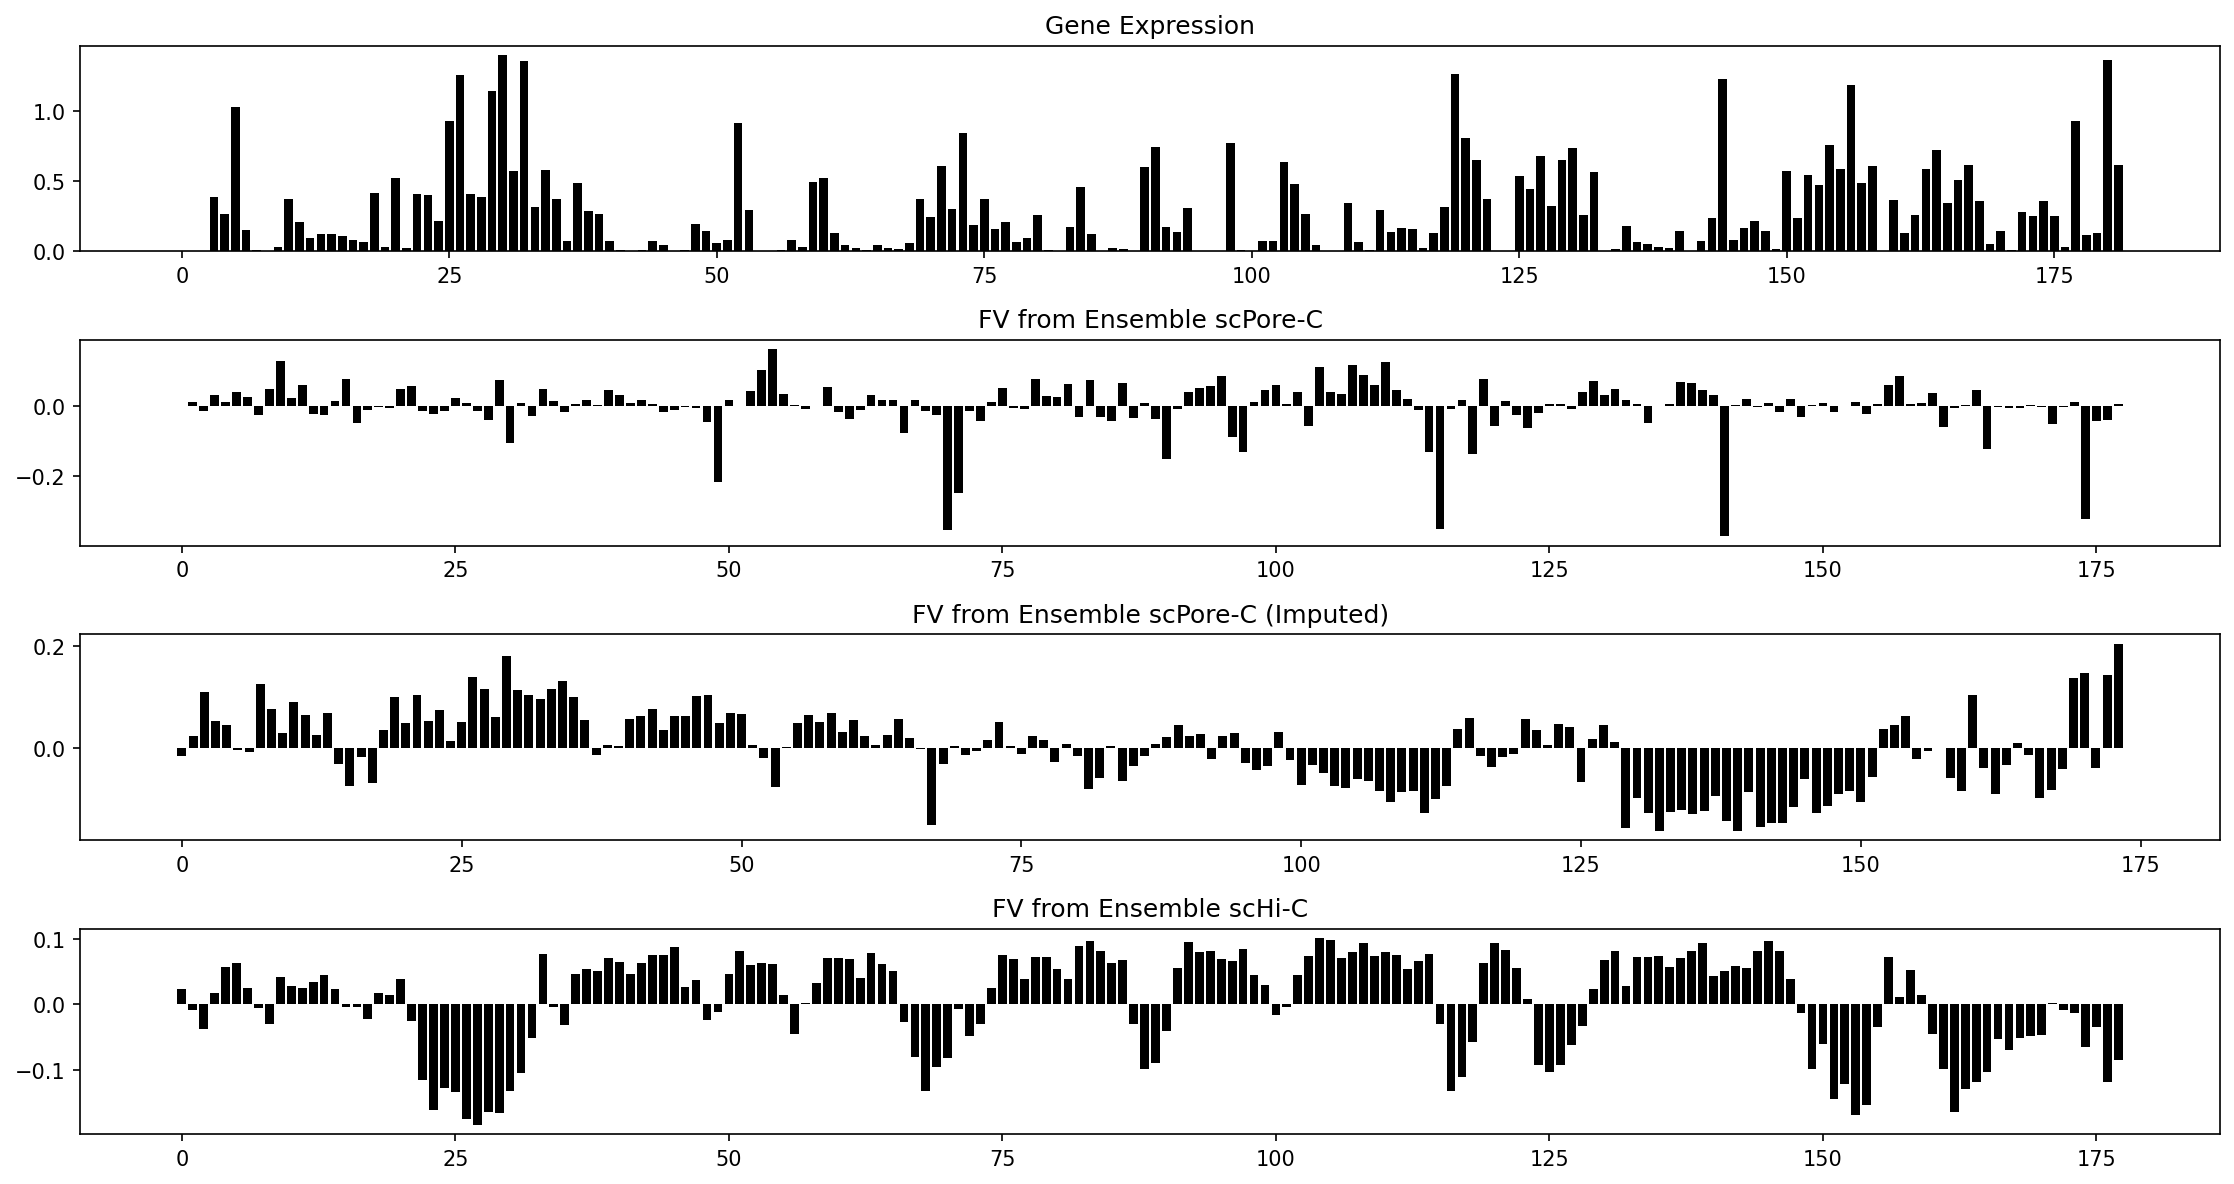

In [54]:

plt.rcParams['figure.dpi'] = 150
plt.rcParams['figure.figsize'] = 15, 8

fig = plt.figure()


fig.add_subplot(4, 1, 1)

rpkm = rna['rpkm'].to_numpy()

plt.bar(range(len(rpkm)), rpkm, color='k')
plt.title('Gene Expression')

fig.add_subplot(4, 1, 2)

plt.bar(range(len(ensembleFied)), ensembleFied, color='k')
plt.title('FV from Ensemble scPore-C')

fig.add_subplot(4, 1, 3)

plt.bar(range(len(imputedFied)), imputedFied, color='k')
plt.title('FV from Ensemble scPore-C (Imputed)')


fig.add_subplot(4, 1, 4)

plt.bar(range(len(naganoFied)), naganoFied, color='k')
plt.title('FV from Ensemble scHi-C')

plt.tight_layout()

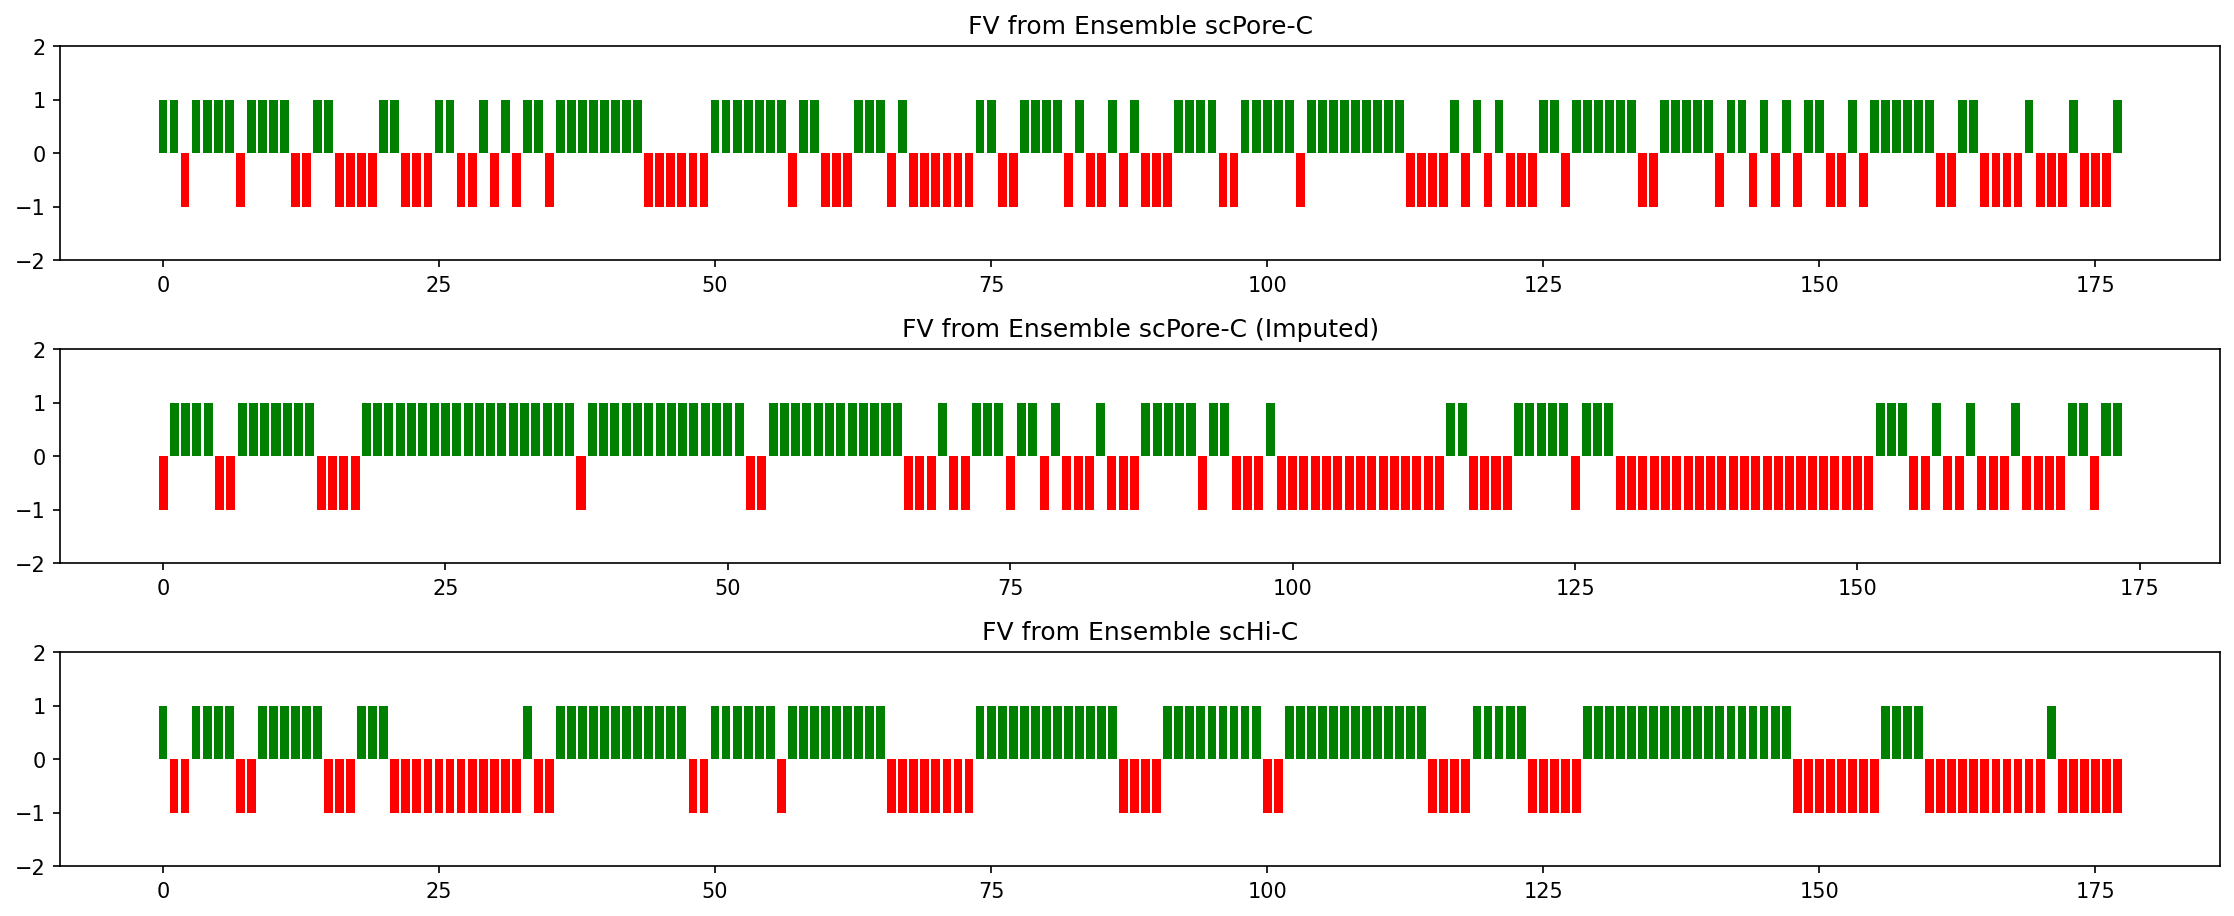

In [53]:

plt.rcParams['figure.dpi'] = 150
plt.rcParams['figure.figsize'] = 15, 8

def makeBars(vec, t=0, vals=(-1, 1), colors=('g', 'r')):
    """A function to process binary vectors for a bar plot """
    v = np.where(vec < t, vals[0], vals[1])
    c = np.where(v == vals[1], colors[0], colors[1])
    i = list(range(len(v)))
    return v, c, i
    

fig = plt.figure()

fig.add_subplot(4, 1, 1)
v, c, i = makeBars(ensembleFied)
plt.bar(i, v, color=c)
plt.ylim(-2, 2)
plt.title('FV from Ensemble scPore-C')

fig.add_subplot(4, 1, 2)
v, c, i = makeBars(imputedFied)
plt.bar(i, v, color=c)
plt.ylim(-2, 2)
plt.title('FV from Ensemble scPore-C (Imputed)')

fig.add_subplot(4, 1, 3)
v, c, i = makeBars(naganoFied)
plt.bar(i, v, color=c)
plt.ylim(-2, 2)
plt.title('FV from Ensemble scHi-C')

plt.tight_layout()

Text(0.5, 1.0, 'Gene Expression')

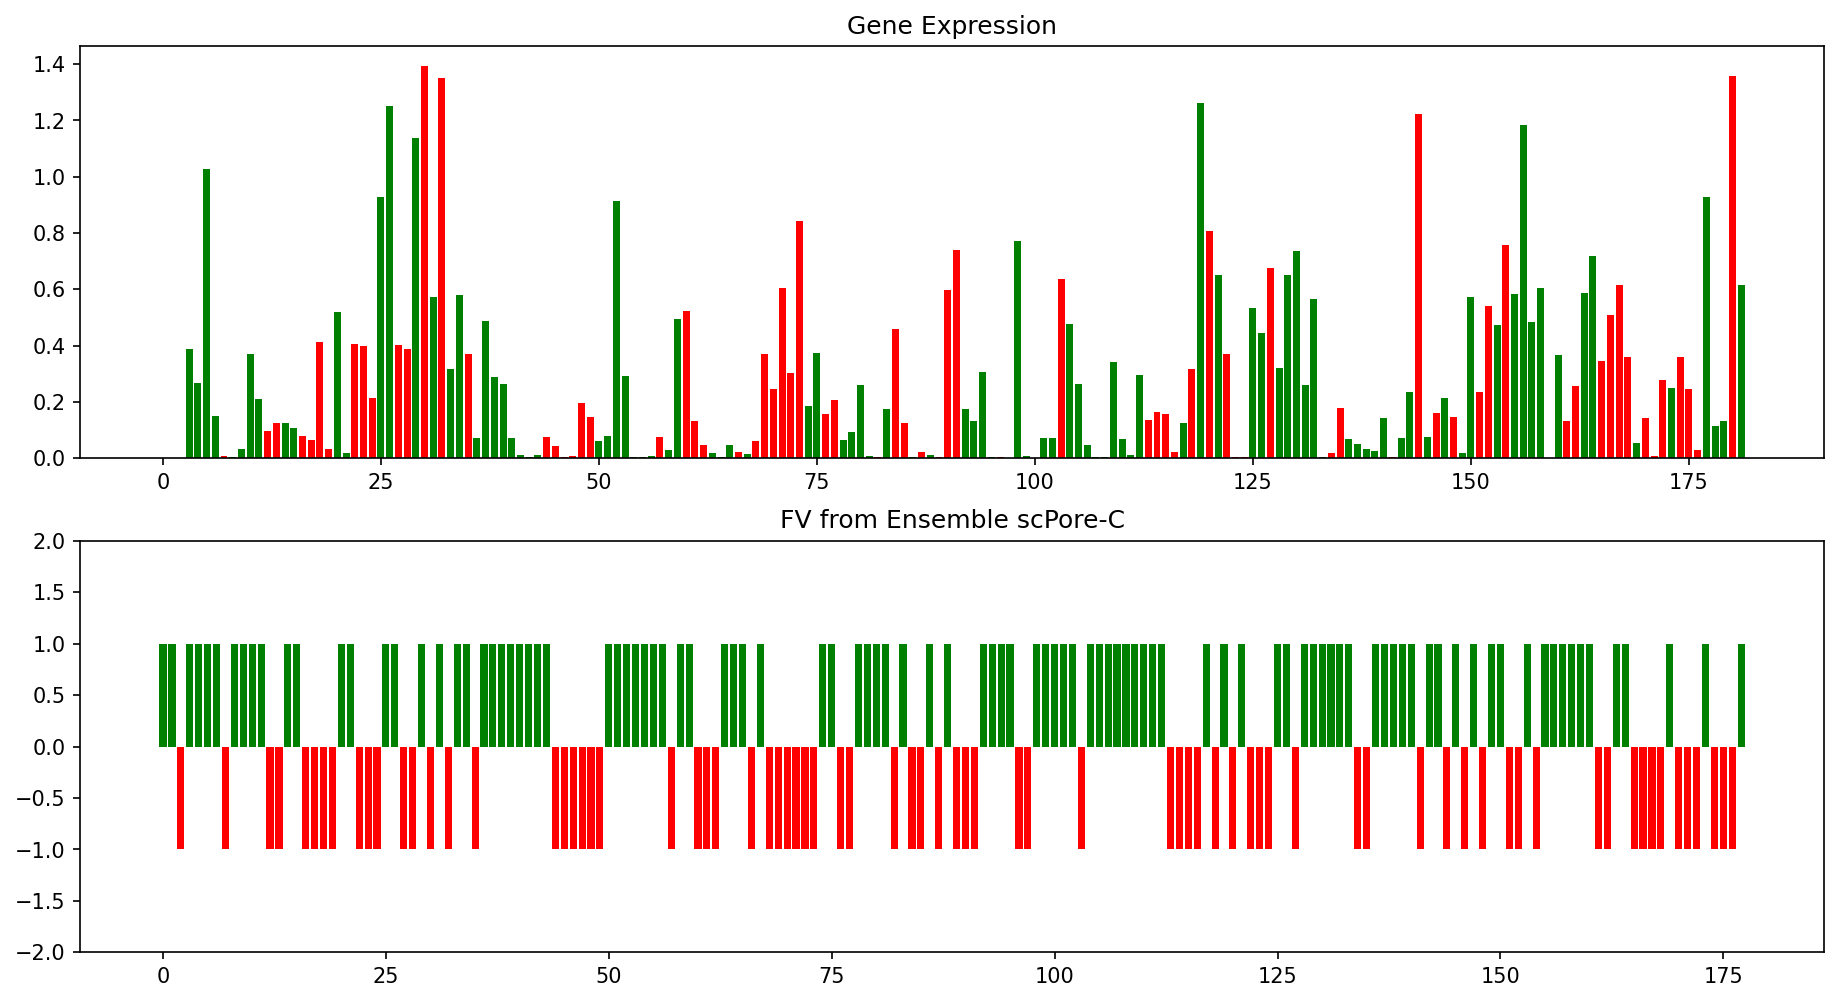

In [56]:

plt.rcParams['figure.dpi'] = 150
plt.rcParams['figure.figsize'] = 15, 8

def makeBars(vec, t=0, vals=(-1, 1), colors=('g', 'r')):
    """A function to process binary vectors for a bar plot """
    v = np.where(vec < t, vals[0], vals[1])
    c = np.where(v == vals[1], colors[0], colors[1])
    i = list(range(len(v)))
    return v, c, i
    

fig = plt.figure()

fig.add_subplot(2, 1, 2)
v, c, i = makeBars(ensembleFied)
plt.bar(i, v, color=c)
plt.ylim(-2, 2)
plt.title('FV from Ensemble scPore-C')

fig.add_subplot(2, 1, 1)
plt.bar(range(len(rpkm)), rpkm, color=c)
plt.title('Gene Expression')

Text(0.5, 1.0, 'Gene Expression')

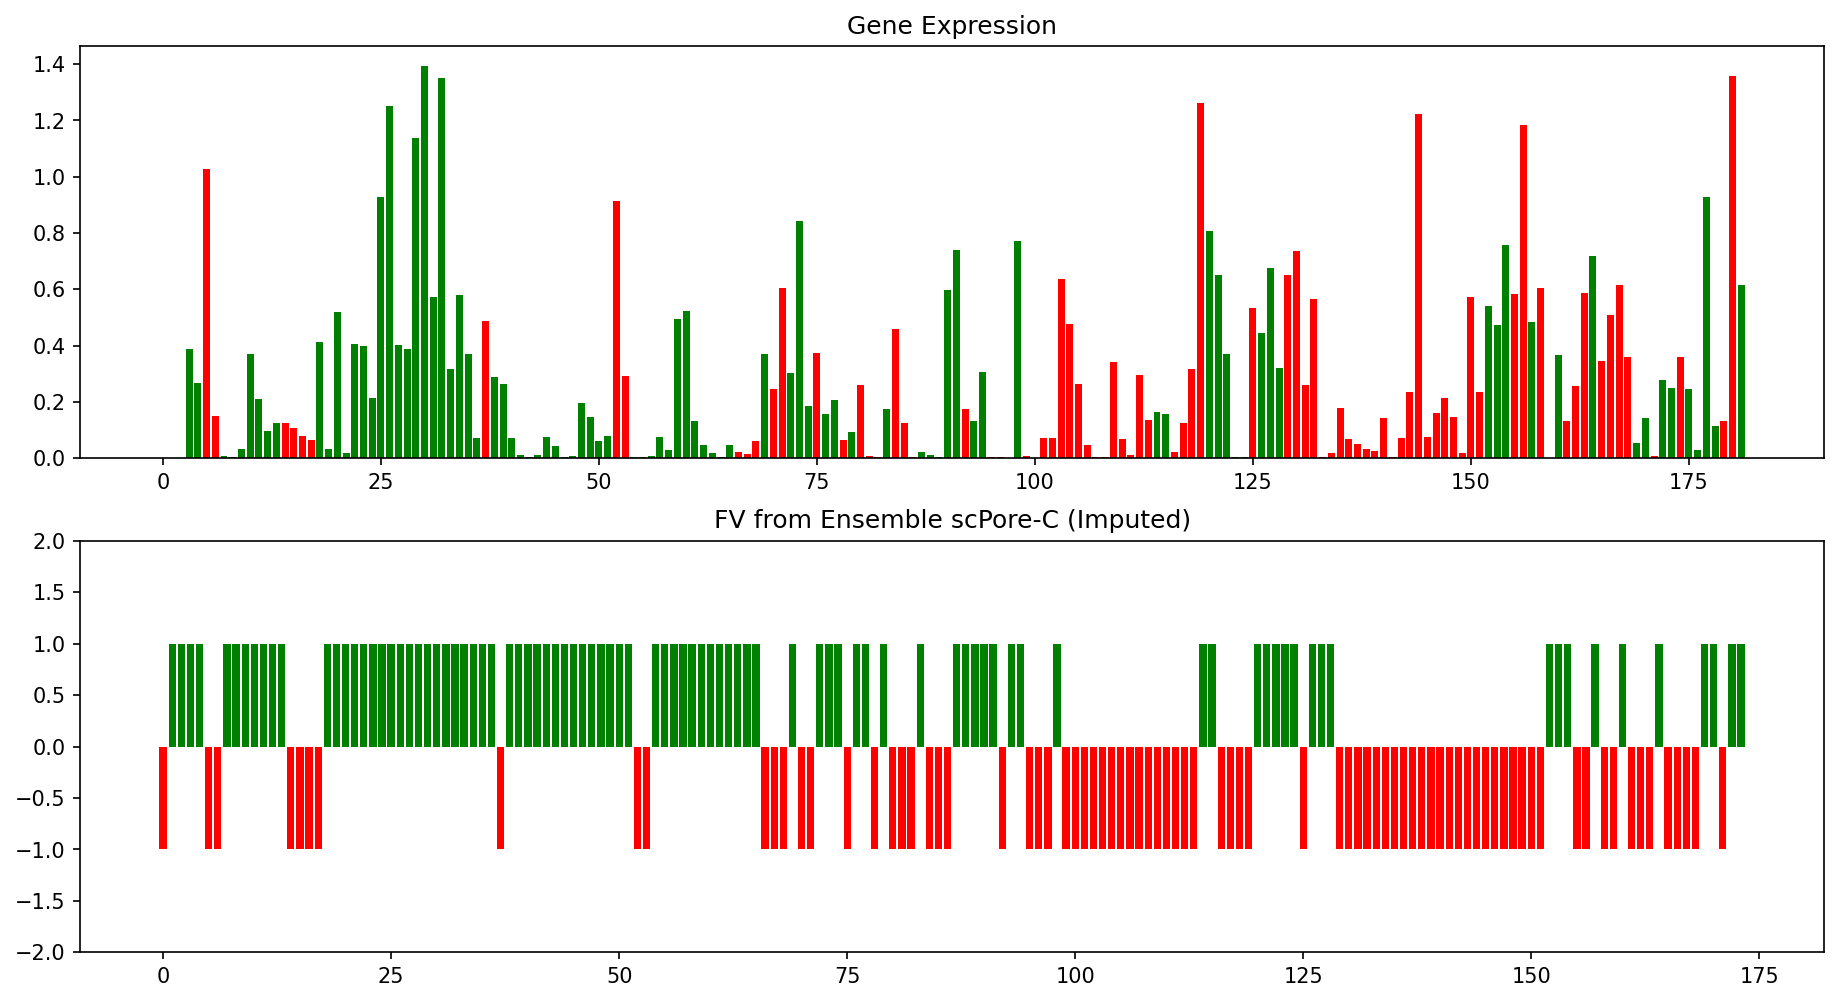

In [57]:

plt.rcParams['figure.dpi'] = 150
plt.rcParams['figure.figsize'] = 15, 8

def makeBars(vec, t=0, vals=(-1, 1), colors=('g', 'r')):
    """A function to process binary vectors for a bar plot """
    v = np.where(vec < t, vals[0], vals[1])
    c = np.where(v == vals[1], colors[0], colors[1])
    i = list(range(len(v)))
    return v, c, i
    

fig = plt.figure()

fig.add_subplot(2, 1, 2)
v, c, i = makeBars(imputedFied)
plt.bar(i, v, color=c)
plt.ylim(-2, 2)
plt.title('FV from Ensemble scPore-C (Imputed)')

fig.add_subplot(2, 1, 1)
plt.bar(range(len(rpkm)), rpkm, color=c)
plt.title('Gene Expression')

Text(0.5, 1.0, 'Gene Expression')

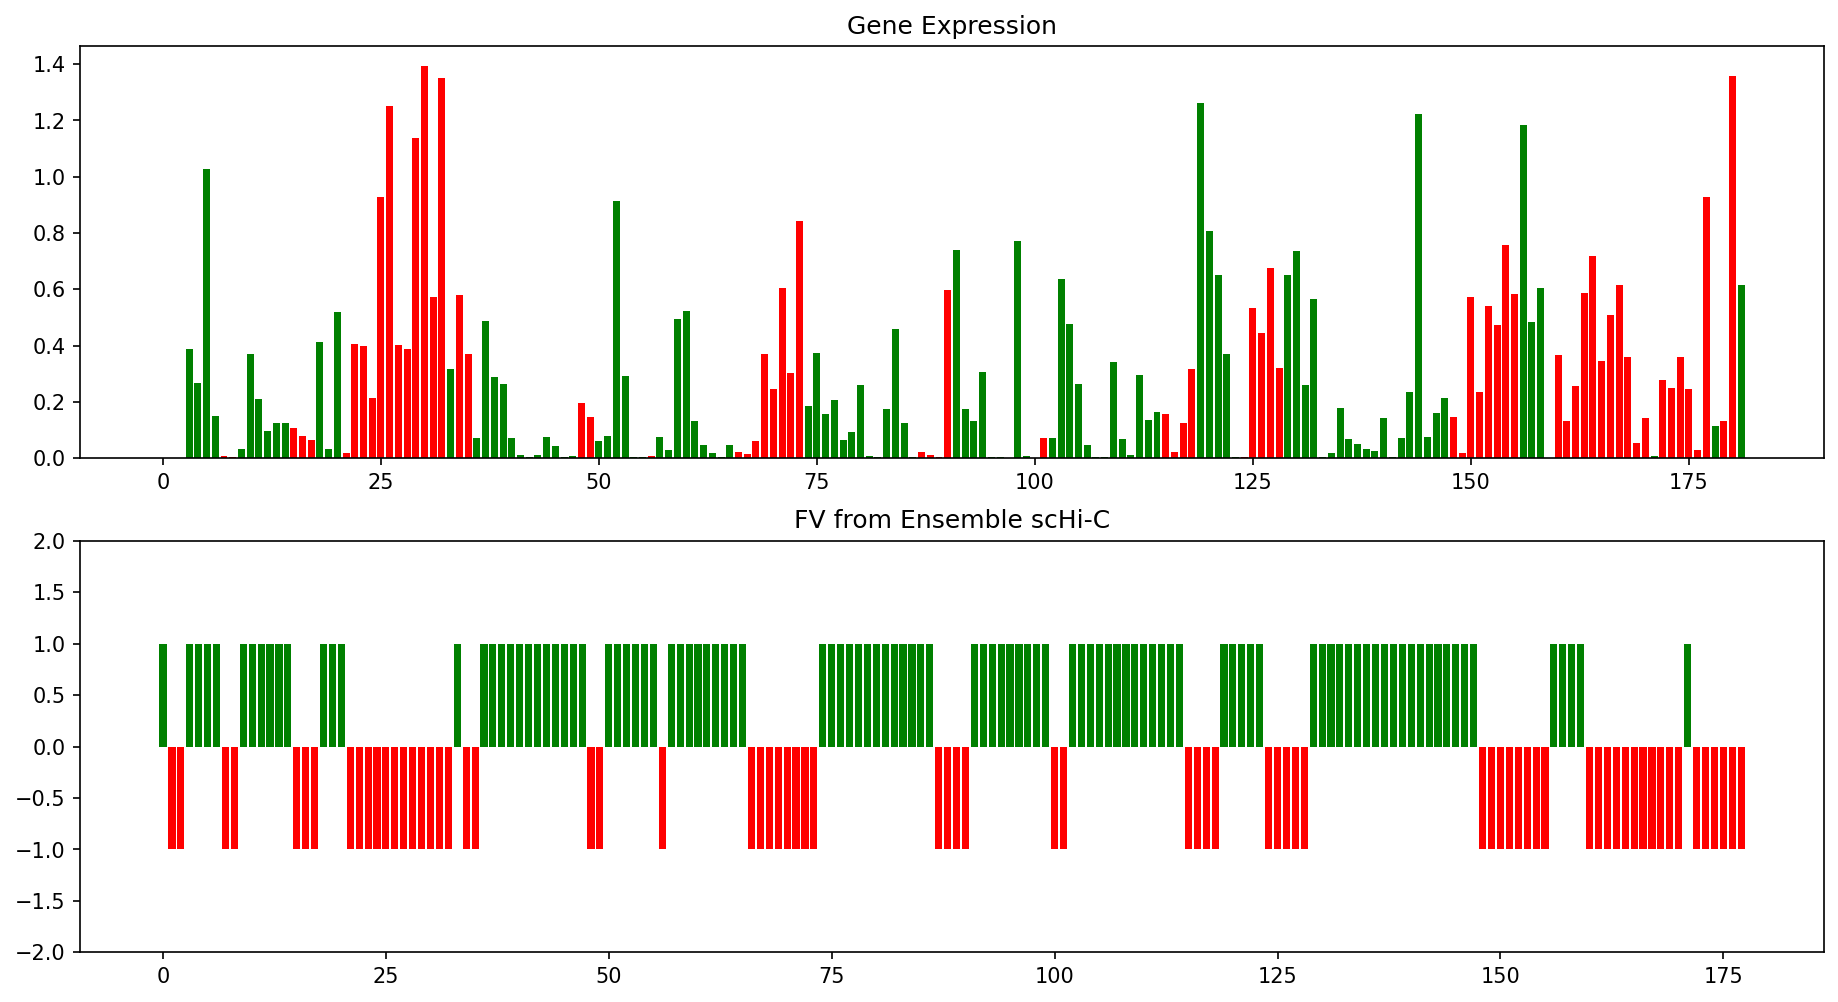

In [58]:

plt.rcParams['figure.dpi'] = 150
plt.rcParams['figure.figsize'] = 15, 8

def makeBars(vec, t=0, vals=(-1, 1), colors=('g', 'r')):
    """A function to process binary vectors for a bar plot """
    v = np.where(vec < t, vals[0], vals[1])
    c = np.where(v == vals[1], colors[0], colors[1])
    i = list(range(len(v)))
    return v, c, i
    

fig = plt.figure()

fig.add_subplot(2, 1, 2)
v, c, i = makeBars(naganoFied)
plt.bar(i, v, color=c)
plt.ylim(-2, 2)
plt.title('FV from Ensemble scHi-C')

fig.add_subplot(2, 1, 1)
plt.bar(range(len(rpkm)), rpkm, color=c)
plt.title('Gene Expression')

In [34]:
break

SyntaxError: 'break' outside loop (<ipython-input-34-6aaf1f276005>, line 1)

# Train MAGIC on scHi-C, Impute scPore-C

In [ ]:
Apool = np.zeros((182, 182))

for runId, A in hic.items():
    Apool += A

Apool, rmInd = pcu.dropZeroRows(Apool, threshold=700, return_ind=True)
print(f"{Apool.shape}")

In [ ]:
# flatten the arrays
flat = []

count = -1
n = 100

for runId, A in hic.items():
    count += 1
    if count < n:
        A = np.asarray(A)
        np.fill_diagonal(A, 1)
    #     A = pcu.forceAdjacentConnections(A)

        A = np.delete(A, rmInd, axis=0)
        A = np.delete(A, rmInd, axis=1)

        Ashape = A.shape
        flat.append(A.flatten())
    

print(f"{Ashape=}")
flat = np.asarray(flat)
print(f"{flat.shape=}")


magic_operator = magic.MAGIC(verbose=False,
                             knn=3,
                             t=3, 
                             n_pca=100)

magic_operator.fit(flat)
multiCellPred = magic_operator.transform(flat)

Apool = np.zeros(Ashape)

for i in range(multiCellPred.shape[0]):
    cell = multiCellPred[i, :]
    cell = cell.reshape(Ashape)
    Apool += cell
    
Aplot = np.where(Apool > 0, np.log(Apool), Apool)
plt.imshow(Aplot, cmap='binary')

In [ ]:
# flatten the arrays
flat = []

for runId, A in rawMatricesChr2.items():
    A = np.asarray(A)
    np.fill_diagonal(A, 1)
    A = pcu.forceAdjacentConnections(A)
    
    A = np.delete(A, rmInd, axis=0)
    A = np.delete(A, rmInd, axis=1)
    
    Ashape = A.shape
    flat.append(A.flatten())
    
# make into array of correct size by duplicating cells 
flat = flat * 17

print(f"{Ashape=}")
flat = np.asarray(flat[:-2])
print(f"{flat.shape=}")

porePred = magic_operator.transform(flat)

Apool = np.zeros(Ashape)

for i in range(6):
    cell = porePred[i, :]
    cell = cell.reshape(Ashape)
    Apool += cell
    

Anormed = pcu.normalizeToeplitz(Apool)

Acorr = np.corrcoef(Anormed)
u, s, vh = np.linalg.svd(Acorr)

pc1 = u[:, 0]

# get Laplacian
L = csgraph.laplacian(Anormed, normed=True)
w, v = np.linalg.eigh(L)

fIndx = 1 # second position

fiedlerNumber = w[fIndx]
fiedlerVector = v[:, fIndx]

left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.05

hicPlotSize = [left, bottom, width, height]
newBottom = bottom + 0.69 + spacing
barPlotSize = [left, newBottom, width, 0.1]
barPlotSize2 = [left, newBottom + 0.14 + spacing, width, 0.1]

fig = plt.figure()
    
ax1 = fig.add_axes(hicPlotSize)

Aplot = Apool

ax1.imshow(Aplot, cmap='binary')
ax1.set_title(f'MAGIC Imputed scPore-C')

ax2 = fig.add_axes(barPlotSize, sharex=ax1)
ax2.bar(range(len(pc1)), pc1, color='k')
ax2.set_title(f'Principal Eigenvector')

ax3 = fig.add_axes(barPlotSize2, sharex=ax1)
ax3.bar(range(len(fiedlerVector)), fiedlerVector, color='k')
ax3.set_title(f'Fiedler Vector')